In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
from catboost import CatBoostClassifier, Pool, utils
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import (
    HalvingRandomSearchCV,
    cross_val_score,
    train_test_split,
)
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from yellowbrick.model_selection import RFECV


In [2]:
train = pd.read_csv("train.csv", sep=",")
test = pd.read_csv("test.csv", sep=",")


# Data Exploration


## Basic


In [3]:
train.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [4]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
# Columns VIP, CryoSleep have type object, convert to bool
train[["VIP", "CryoSleep"]] = train[["VIP", "CryoSleep"]].astype(bool)
test[["VIP", "CryoSleep"]] = test[["VIP", "CryoSleep"]].astype(bool)


In [6]:
train.describe()


,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


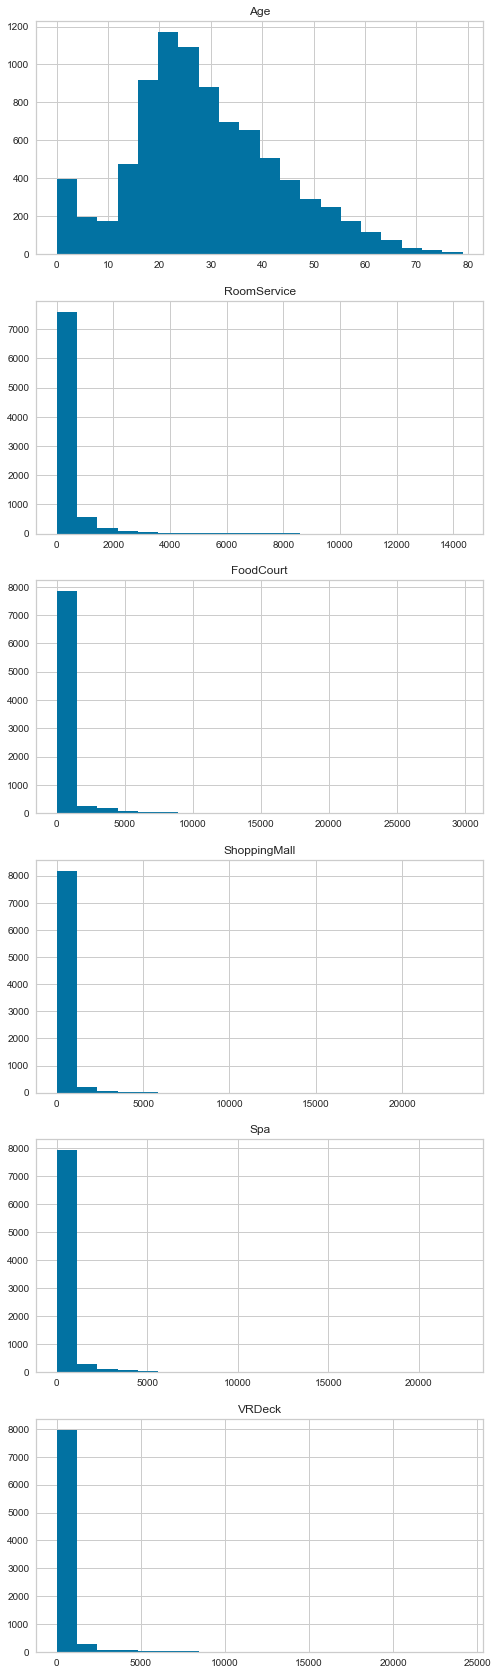

In [7]:
# Plot the distribution of all numeric columns in multiple graphs
numerical_cols = train.select_dtypes(include="number").columns
fig, ax = plt.subplots(len(numerical_cols), 1, figsize=(8, len(numerical_cols) * 5))

for i, col in enumerate(numerical_cols):
    ax[i].hist(train[col], bins=20)
    ax[i].set_title(col)


In [8]:
# All columns besides age have a really uneven distribution,
# we will take the log1p of the value for these columns
for col in numerical_cols:
    if col != "Age":
        train[col] = np.log1p(train[col])
        test[col] = np.log1p(test[col])


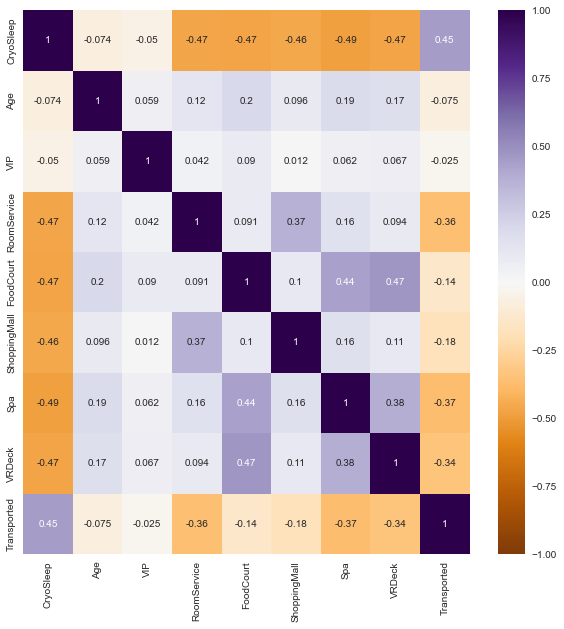

In [9]:
# plot correlation matrix of train df
corr = train.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, center=0, cmap="PuOr")
plt.show()


In [10]:
train.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,4.700480,2.302585,3.258097,6.309918,3.806662,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,3.784190,8.182280,0.000000,8.812248,3.912023,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.000000,7.157735,5.918894,8.110728,5.267858,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,5.717028,4.262680,5.023881,6.338594,1.098612,Willy Santantines,True


## Feature Engineering

In [11]:
def add_features(df):
    # Add the number of people in the same cabin as the passenger
    df["CabinCount"] = df.groupby("Cabin")["PassengerId"].transform("count")
    df["IsAlone"] = (df["CabinCount"] == 1).astype(bool)

    # Add the number of people going to the same destination as the passenger
    df["DestinationCount"] = df.groupby("Destination")["PassengerId"].transform("count")

    # Bin age groups
    df["AgeBin"] = pd.cut(df.Age, bins=[0, 18, 35, 50, 80], include_lowest=True)
    df["Premium"] = df["RoomService"] + df["Spa"] + df["VRDeck"]
    df["Essential"] = df["FoodCourt"] + df["ShoppingMall"]

    return df


try:
    train = add_features(train)
    test = add_features(test)
except KeyError:
    print("Already added features")


## Categorical Features transformations


In [12]:
def preprocess_passenger_id(df: pd.DataFrame, test_set=False):
    """
    Preprocess the passenger ID column by splitting it into two columns:
    - GroupID: the group ID of the passenger
    - PassID: the individual ID of the passenger within the group
    """
    df[["GroupID", "PassID"]] = df["PassengerId"].str.split("_", expand=True)
    df["GroupID"] = df["GroupID"].astype(int)
    df["PassID"] = df["PassID"].astype(int)
    if test_set:
        # set aside the ID for prediction later
        passenger_id = df["PassengerId"].copy()
    df.drop("PassengerId", axis=1, inplace=True)
    return (df, passenger_id) if test_set else (df, None)


def preprocess_cabin(df: pd.DataFrame):
    """
    Preprocess the cabin column by splitting it into three columns:
    - CabinDeck: the first letter of the cabin
    - CabinNum: the rest of the cabin
    - CabinSide: the side of cabin
    """
    df["Cabin"] = df["Cabin"].fillna("missing/-1/missing")
    df[["CabinDeck", "CabinNum", "CabinSide"]] = df["Cabin"].str.split("/", expand=True)
    df["CabinNum"] = df["CabinNum"].astype(int)
    # Bin Cabin Numbers
    # df["CabinNumberBin"] = pd.cut(
    #     df.CabinNum, bins=[0, 270, 600, 1150, 1500, 2000], include_lowest=True
    # )
    df.drop("Cabin", axis=1, inplace=True)
    return df


In [13]:
# ID column to be separated between before and after the "_"
try:
    train, _ = preprocess_passenger_id(train, test_set=False)
    test, passenger_id = preprocess_passenger_id(test, test_set=True)
except KeyError:
    print("ID already split")

# Cabin column to be split into 3, separated by "/" (deck/num/side)
# We replace NaN by missing/-1/missing to signal missing cabin information
try:
    train = preprocess_cabin(train)
    test = preprocess_cabin(test)
except KeyError:
    print("Cabin already split")

# Processing of the Name column: keep only last name ?
# Drop completely because same family is probably in the same cabin ?
# For now, 2nd option
try:
    train.drop("Name", axis=1, inplace=True)
    test.drop("Name", axis=1, inplace=True)
except KeyError:
    print("Name already dropped")


In [14]:
def impute_home_planet(df):
    """
    Replace NaN for HomePlanet by the value of the other people in the group
    if possible (takes max of the other values if multiple planets)
    """
    df_grp = (
        df.groupby(["GroupID", "HomePlanet"])["HomePlanet"].size().unstack().fillna(0)
    )
    ids_of_nan_in_group = df[df["HomePlanet"].isna()][
        (df[df["HomePlanet"].isna()]["GroupID"]).isin(df_grp.index)
    ].index

    df.loc[ids_of_nan_in_group, "HomePlanet"] = df.iloc[ids_of_nan_in_group, :][
        "GroupID"
    ].map(lambda x: df_grp.idxmax(axis=1)[x])

    return df


try:
    train = impute_home_planet(train)
    test = impute_home_planet(test)
except AttributeError:
    print("Already imputed")


In [15]:
# Transform categories to OrdinalEncoding
train[["AgeBin"]] = train[["AgeBin"]].apply(lambda x: x.cat.codes)
test[["AgeBin"]] = test[["AgeBin"]].apply(lambda x: x.cat.codes)


In [16]:
train.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,...,IsAlone,DestinationCount,AgeBin,Premium,Essential,GroupID,PassID,CabinDeck,CabinNum,CabinSide
0,Europa,False,TRAPPIST-1e,39.0,False,0.000000,0.000000,0.000000,0.000000,0.000000,...,True,5915.0,2,0.000000,0.000000,1,1,B,0,P
1,Earth,False,TRAPPIST-1e,24.0,False,4.700480,2.302585,3.258097,6.309918,3.806662,...,True,5915.0,1,14.817061,5.560682,2,1,F,0,S
2,Europa,False,TRAPPIST-1e,58.0,True,3.784190,8.182280,0.000000,8.812248,3.912023,...,False,5915.0,3,16.508461,8.182280,3,1,A,0,S
3,Europa,False,TRAPPIST-1e,33.0,False,0.000000,7.157735,5.918894,8.110728,5.267858,...,False,5915.0,1,13.378586,13.076629,3,2,A,0,S
4,Earth,False,TRAPPIST-1e,16.0,False,5.717028,4.262680,5.023881,6.338594,1.098612,...,True,5915.0,0,13.154234,9.286560,4,1,F,1,S


In [17]:
object_cols = train.select_dtypes(["object", "category"]).columns

for col in object_cols:
    print(col, ":", train[col].nunique(), "unique values")
# few unique values: one Hot encoding is suitable


HomePlanet : 3 unique values
Destination : 3 unique values
CabinDeck : 9 unique values
CabinSide : 3 unique values


## Train & Validation sets


In [18]:
X_train, X_valid, y_train, y_valid = train_test_split(
    train.drop("Transported", axis=1),
    train["Transported"],
    test_size=0.2,
)


## Imputation


In [19]:
# look at percentage of missing values in each column
na_cols = [col for col in train.columns if train[col].isna().sum() > 0]
for col in na_cols:
    print(f"{col}: {train[col].isna().sum()/train.shape[0]*100:.2f}%")

# Around 2% missing data per column in training data


HomePlanet: 1.28%
Destination: 2.09%
Age: 2.06%
RoomService: 2.08%
FoodCourt: 2.11%
ShoppingMall: 2.39%
Spa: 2.11%
VRDeck: 2.16%
CabinCount: 2.29%
DestinationCount: 2.09%
Premium: 6.26%
Essential: 4.47%


In [20]:
X_train_impute, X_valid_impute = X_train.copy(), X_valid.copy()
X_test_impute = test.copy()


In [21]:
X_train_impute.isna().sum()

HomePlanet           89
CryoSleep             0
Destination         149
Age                 150
VIP                   0
RoomService         143
FoodCourt           144
ShoppingMall        168
Spa                 143
VRDeck              151
CabinCount          152
IsAlone               0
DestinationCount    149
AgeBin                0
Premium             430
Essential           311
GroupID               0
PassID                0
CabinDeck             0
CabinNum              0
CabinSide             0
dtype: int64

In [22]:
# imputation of categorical columns with "most_frequent" strategy
imputer = SimpleImputer(strategy="most_frequent")
X_train_impute[object_cols] = imputer.fit_transform(
    X_train_impute[object_cols]
    .to_numpy()
    .reshape(-1, X_train_impute[object_cols].shape[1])
)
X_valid_impute[object_cols] = imputer.transform(
    X_valid_impute[object_cols]
    .to_numpy()
    .reshape(-1, X_valid_impute[object_cols].shape[1])
)
X_test_impute[object_cols] = imputer.transform(
    X_test_impute[object_cols]
    .to_numpy()
    .reshape(-1, X_test_impute[object_cols].shape[1])
)

# Iterative imputation for numerical columns
numerical_cols = train.select_dtypes(include=["float64", "int32", "int8"]).columns
imputer = IterativeImputer(max_iter=100, sample_posterior=True)
X_train_impute[numerical_cols] = imputer.fit_transform(
    X_train_impute[numerical_cols]
    .to_numpy()
    .reshape(-1, X_train_impute[numerical_cols].shape[1])
)
X_valid_impute[numerical_cols] = imputer.transform(
    X_valid_impute[numerical_cols]
    .to_numpy()
    .reshape(-1, X_valid_impute[numerical_cols].shape[1])
)
X_test_impute[numerical_cols] = imputer.transform(
    X_test_impute[numerical_cols]
    .to_numpy()
    .reshape(-1, X_test_impute[numerical_cols].shape[1])
)

# Recreate DataFrames
X_train_impute = pd.DataFrame(X_train_impute, columns=X_train.columns)
X_valid_impute = pd.DataFrame(X_valid_impute, columns=X_valid.columns)
X_test_impute = pd.DataFrame(X_test_impute, columns=test.columns)


In [23]:
X_train_impute.isna().sum()


HomePlanet          0
CryoSleep           0
Destination         0
Age                 0
VIP                 0
RoomService         0
FoodCourt           0
ShoppingMall        0
Spa                 0
VRDeck              0
CabinCount          0
IsAlone             0
DestinationCount    0
AgeBin              0
Premium             0
Essential           0
GroupID             0
PassID              0
CabinDeck           0
CabinNum            0
CabinSide           0
dtype: int64

In [24]:
# Children under 13 should not have paid anything
# Replace values of RoomService, FoodCourt, ShoppingMall, Spa, VRDeck by 0 for children under 13

def replace_children(df, threshold=13):
    df.loc[
        df["Age"] < threshold,
        ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"],
    ] = 0
    return df


X_train_impute = replace_children(X_train_impute)
X_valid_impute = replace_children(X_valid_impute)
X_test_impute = replace_children(X_test_impute)

# Same for people in CryoSleep
def replace_cryo(df):
    df.loc[
        df["CryoSleep"] == True,
        ["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"],
    ] = 0
    return df

X_train_impute = replace_cryo(X_train_impute)
X_valid_impute = replace_cryo(X_valid_impute)
X_test_impute = replace_cryo(X_test_impute)

## One Hot Encoding


In [25]:
label_binarizer = OneHotEncoder(sparse=False)

train_ohe_cols = pd.DataFrame(
    label_binarizer.fit_transform(X_train_impute[object_cols])
)
valid_ohe_cols = pd.DataFrame(label_binarizer.transform(X_valid_impute[object_cols]))
test_ohe_cols = pd.DataFrame(label_binarizer.transform(X_test_impute[object_cols]))

train_ohe_cols.index = X_train_impute.index
valid_ohe_cols.index = X_valid_impute.index
test_ohe_cols.index = X_test_impute.index

num_X_train_impute = X_train_impute.drop(object_cols, axis=1)
num_X_valid_impute = X_valid_impute.drop(object_cols, axis=1)
num_X_test_impute = X_test_impute.drop(object_cols, axis=1)

X_train_ohe_impute = pd.concat([num_X_train_impute, train_ohe_cols], axis=1)
X_valid_ohe_impute = pd.concat([num_X_valid_impute, valid_ohe_cols], axis=1)
X_test_ohe_impute = pd.concat([num_X_test_impute, test_ohe_cols], axis=1)


In [26]:
X_train_impute.shape, X_valid_impute.shape, X_train_ohe_impute.shape, X_valid_ohe_impute.shape


((6954, 22), (1739, 22), (6954, 36), (1739, 36))

# Model


## XGBoost

In [19]:
model = XGBClassifier(verbosity=0)
model.fit(X_train_ohe_impute, y_train)


C:\Users\Maxime\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=0)

In [20]:
cross_val_score(
    model, X_valid_ohe_impute, y_valid, scoring="f1", cv=10, n_jobs=8
).mean()


0.7786599890669685

## LightGBM

In [25]:
# Do not use OHE, but use pandas categories and let lightgbm handle them
def process_categorical(df):
    for c in df.columns:
        col_type = df[c].dtype
        if col_type == "object" or col_type.name == "category":
            df[c] = df[c].astype("category")

    return df


X_train_impute = process_categorical(X_train_impute)
X_valid_impute = process_categorical(X_valid_impute)
X_test_impute = process_categorical(X_test_impute)


In [26]:
train_dataset = lgb.Dataset(X_train_impute, label=y_train)
valid_dataset = lgb.Dataset(X_valid_impute, label=y_valid)
test_dataset = lgb.Dataset(X_test_impute)
full_train_dataset = lgb.Dataset(pd.concat([X_train_impute, X_valid_impute]), label=pd.concat([y_train, y_valid]))

In [28]:
params = {
    "objective": "binary",
    "loss_function": "Logloss",
    "custom_metric": "AUC",
    "eval_metric": "Accuracy",
    "min_data_in_leaf": 100,
    "num_leaves": 200,
    "n_jobs": 12,
}

model_lgb = lgb.LGBMClassifier(
    **params,
)

model_lgb.fit(
    X=X_train_impute,
    y=y_train,
    eval_set=(X_valid_impute, y_valid),
    feature_name="auto",
    categorical_feature="auto",
    callbacks=[
        lgb.early_stopping(stopping_rounds=100),
        lgb.log_evaluation(period=10),
    ],
)


C:\Users\Maxime\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\Maxime\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


Training until validation scores don't improve for 100 rounds
[10]	valid_0's binary_logloss: 0.488612
[20]	valid_0's binary_logloss: 0.434262
[30]	valid_0's binary_logloss: 0.411443
[40]	valid_0's binary_logloss: 0.40031
[50]	valid_0's binary_logloss: 0.396882
[60]	valid_0's binary_logloss: 0.394454
[70]	valid_0's binary_logloss: 0.395189
[80]	valid_0's binary_logloss: 0.395961
[90]	valid_0's binary_logloss: 0.396822
[100]	valid_0's binary_logloss: 0.397396
Did not meet early stopping. Best iteration is:
[60]	valid_0's binary_logloss: 0.394454


LGBMClassifier(custom_metric='AUC', eval_metric='Accuracy',
               loss_function='Logloss', min_data_in_leaf=100, n_jobs=12,
               num_leaves=200, objective='binary')

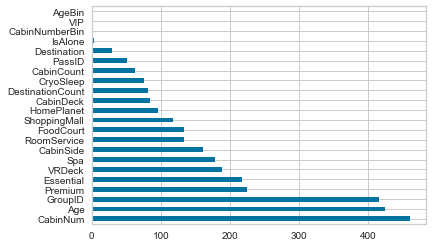

In [33]:
feat_imp = pd.Series(model_lgb.feature_importances_, index=X_train_impute.columns)
feat_imp.nlargest(30).plot(kind="barh")
plt.show()

In [34]:
accuracy_score(y_valid, model_lgb.predict(X_valid_impute))

0.8085106382978723

In [23]:
%%script echo skipping

# Use RandomSearchCV to find the best parameters

params = {
    "objective": ["binary"],
    "metric": ["auc"],
    "boosting_type": ["gbdt", "dart", "goss"],
    "num_iterations": [100, 200, 300],
    "min_data_in_leaf": [10, 50, 100, 200, 500],
    "num_leaves": np.arange(10, 61, 10),
    "bagging_fraction": np.arange(0.2, 1.1, 0.2),
    "bagging_freq": np.arange(0, 11, 3),
    "drop_rate": np.arange(0, 0.51, 0.1),
    "reg_alpha": np.arange(0, 1.1, 0.2),
    "reg_lambda": np.arange(0, 1.1, 0.2),
    "extra_trees": [True],
    "xgboost_dart_mode": [True],
    "n_jobs": [8],
}

grid = HalvingRandomSearchCV(
    estimator=lgb.LGBMClassifier(),
    resource="n_estimators",
    param_distributions=params,
    factor=3,
    scoring="f1",
    min_resources=10,
    max_resources=1000,
    cv=5,
    n_jobs=8,
    verbose=0,
    error_score=0,
)

grid.fit(X_train_ohe_impute, y_train)
print(grid.best_estimator_)
cross_val_score(
    grid.best_estimator_, X_valid_ohe_impute, y_valid, scoring="f1", cv=10, n_jobs=8
).mean()


skipping


### Results of models on validation set

|                                                                | xgboost   | lightgbm  |
| -------------------------------------------------------------- | --------- | --------- |
| ~no parameter tuning </br> no data imputation                  | **0.764** | 0.774     |
| no parameter tuning </br> data imputation                      | 0.764     | 0.778     |
| parameter tuning </br> data imputation                         |           | **0.798** |
| parameter tuning </br> data imputation </br> feature selection |           | 0.786     |


In [30]:
best_model = lgb.LGBMClassifier(
    bagging_fraction=0.8,
    bagging_freq=3,
    drop_rate=0.3,
    extra_trees=True,
    metric="auc",
    min_data_in_leaf=100,
    n_estimators=810,
    n_jobs=8,
    num_leaves=50,
    objective="binary",
    reg_lambda=0.8,
    xgboost_dart_mode=True,
)

# Fit on whole dataset did worse
best_model.fit(pd.concat([X_train_ohe_impute, X_valid_ohe_impute]), pd.concat([y_train, y_valid]))

[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


LGBMClassifier(bagging_fraction=0.8, bagging_freq=3, drop_rate=0.3,
               extra_trees=True, metric='auc', min_data_in_leaf=100,
               n_estimators=810, n_jobs=8, num_leaves=50, objective='binary',
               reg_lambda=0.8, xgboost_dart_mode=True)

### Feature Selection lgbm

In [ ]:
%%script echo skipping

best_model = lgb.LGBMClassifier(
    bagging_fraction=0.8,
    bagging_freq=3,
    drop_rate=0.3,
    extra_trees=True,
    metric="auc",
    min_data_in_leaf=100,
    n_estimators=810,
    n_jobs=8,
    num_leaves=50,
    objective="binary",
    reg_lambda=0.8,
    xgboost_dart_mode=True,
)

rfecv = RFECV(best_model, step=1, min_features_to_select=5, scoring="f1", n_jobs=-1)
rfecv.fit(X_train_ohe_impute, y_train)
rfecv.show()


In [59]:
%%script echo skipping

X_train_ohe_impute = pd.DataFrame(rfecv.transform(X_train_ohe_impute), columns=X_train_ohe_impute.columns[rfecv.support_], dtype=np.float32)
X_valid_ohe_impute = pd.DataFrame(rfecv.transform(X_valid_ohe_impute), columns=X_valid_ohe_impute.columns[rfecv.support_], dtype=np.float32)
X_test_ohe_impute = pd.DataFrame(rfecv.transform(X_test_ohe_impute), columns=X_test_ohe_impute.columns[rfecv.support_], dtype=np.float32)
print(X_train_ohe_impute.shape)

best_model.fit(X_train_ohe_impute, y_train)
cross_val_score(
    best_model, X_valid_ohe_impute, y_valid, scoring="f1", cv=10, n_jobs=8
).mean()


C:\Users\Maxime\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Maxime\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\Maxime\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  w

(6954, 27)
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


0.7856987256461065

### Hyperparameter tuning with optuna

In [69]:
def objective(trial):
    train_dataset = lgb.Dataset(X_train_impute, label=y_train)

    param = {
        "objective": "binary",
        "verbosity": -1,
        "max_cat_to_onehot": 5,
        "n_jobs": 12,
        "boosting_type": trial.suggest_categorical("boosting_type", ["dart", "goss"]),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 1e-1),
        "max_bin": trial.suggest_int("max_bin", 64, 1024),
        "max_depth": trial.suggest_int("max_depth", -1, 31, step=4),
        "num_leaves": trial.suggest_int("num_leaves", 32, 256),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-2, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
    }

    if param["boosting_type"] == "goss":
        param["top_rate"] = trial.suggest_float("top_rate", 0.0, 0.5)
        param["other_rate"] = trial.suggest_float("other_rate", 0.0, 0.5)
    elif param["boosting_type"] == "dart":
        param["bagging_fraction"] = trial.suggest_float("bagging_fraction", 0.4, 1.0),
        param["bagging_freq"] = trial.suggest_int("bagging_freq", 1, 10),
        param["drop_rate"] = trial.suggest_loguniform("drop_rate", 1e-3, 2e-1)
        param["max_drop"] = trial.suggest_int("max_drop", 20, 100)
        param["skip_drop"] = trial.suggest_uniform("skip_drop", 0.0, 0.8)

    gbm = lgb.train(param, train_dataset, num_boost_round=trial.suggest_int("num_iterations", 500, 2000), feature_name='auto', categorical_feature='auto')
    preds = gbm.predict(X_valid_impute)
    pred_labels = np.rint(preds)
    accuracy = accuracy_score(y_valid, pred_labels)
    return accuracy


In [70]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=500)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-07-01 20:30:25,352] A new study created in memory with name: no-name-21ed41ac-71c0-47cc-8bef-b2714d49298b
[I 2022-07-01 20:30:27,205] Trial 0 finished with value: 0.8090856814261069 and parameters: {'boosting_type': 'goss', 'learning_rate': 0.027361314102257374, 'max_bin': 503, 'max_depth': 23, 'num_leaves': 220, 'min_data_in_leaf': 75, 'feature_fraction': 0.6589350566535948, 'lambda_l1': 0.623148231742506, 'lambda_l2': 2.1833327108309165e-05, 'top_rate': 0.2705437735525564, 'other_rate': 0.10244717524763625, 'num_iterations': 1204}. Best is trial 0 with value: 0.8090856814261069.
[I 2022-07-01 20:30:30,164] Trial 1 finished with value: 0.8090856814261069 and parameters: {'boosting_type': 'dart', 'learning_rate': 0.0030324643352554405, 'max_bin': 586, 'max_depth': 7, 'num_leaves': 144, 'min_data_in_leaf': 18, 'feature_fraction': 0.9238679118366585, 'lambda_l1': 6.553123695485222, 'lambda_l2': 3.791976447116918, 'bagging_fraction': 0.5075650254178306, 'bagging_freq': 7, 'drop_ra

Number of finished trials: 500
Best trial:
  Value: 0.828637147786084
  Params: 
    boosting_type: dart
    learning_rate: 0.022962889467981827
    max_bin: 722
    max_depth: -1
    num_leaves: 239
    min_data_in_leaf: 83
    feature_fraction: 0.7668498673631298
    lambda_l1: 2.451686108573376
    lambda_l2: 0.28939668547255104
    bagging_fraction: 0.6732931553684648
    bagging_freq: 1
    drop_rate: 0.004823229858926694
    max_drop: 65
    skip_drop: 0.21891187690660008
    num_iterations: 1667


In [71]:
model_best_lgb = lgb.LGBMClassifier(**trial.params)
model_best_lgb.fit(pd.concat([X_train_impute, X_valid_impute]), pd.concat([y_train, y_valid]))


[LightGBM] [Warning] feature_fraction is set=0.7668498673631298, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7668498673631298
[LightGBM] [Warning] min_data_in_leaf is set=83, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=83


C:\Users\Maxime\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] lambda_l1 is set=2.451686108573376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.451686108573376
[LightGBM] [Warning] bagging_fraction is set=0.6732931553684648, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6732931553684648
[LightGBM] [Warning] lambda_l2 is set=0.28939668547255104, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.28939668547255104
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


LGBMClassifier(bagging_fraction=0.6732931553684648, bagging_freq=1,
               boosting_type='dart', drop_rate=0.004823229858926694,
               feature_fraction=0.7668498673631298, lambda_l1=2.451686108573376,
               lambda_l2=0.28939668547255104,
               learning_rate=0.022962889467981827, max_bin=722, max_drop=65,
               min_data_in_leaf=83, num_iterations=1667, num_leaves=239,
               skip_drop=0.21891187690660008)

In [72]:
# Write predictions on the test set to a new dataframe with PassengerId and the result of the model
test_pred = pd.DataFrame(passenger_id, columns=["PassengerId"])
test_pred["Transported"] = model_best_lgb.predict(X_test_impute)
test_pred.to_csv("test_pred_lgb_optuna_500_new.csv", index=False)


## Catboost

In [33]:
%load_ext tensorboard


In [25]:
train_dataset_cat_ohe = Pool(X_train_ohe_impute, label=y_train)
valid_dataset_cat_ohe = Pool(X_valid_ohe_impute, label=y_valid)
test_dataset_cat_ohe = Pool(X_test_ohe_impute)

model_catboost = CatBoostClassifier(
    iterations=1000,
    loss_function="Logloss",
    learning_rate=0.05,
    depth=8,
    eval_metric="F1",
    use_best_model=True,
)

model_catboost.fit(
    train_dataset_cat_ohe,
    eval_set=valid_dataset_cat_ohe,
    use_best_model=True,
    verbose=False,
    plot=True,
    early_stopping_rounds=50,
)


NameError: name 'X_train_ohe_impute' is not defined

In [33]:
# Write predictions on the test set to a new dataframe with PassengerId and the result of the model
test_pred = pd.DataFrame(passenger_id, columns=["PassengerId"])
test_pred["Transported"] = model_catboost.predict(test_dataset_cat_ohe)
test_pred.to_csv("test_pred.csv", index=False)

### Catboost with no OH encoding

In [26]:
# get categorical features
cat_features_indexes = lambda df: df.select_dtypes(include=["object", "category"]).columns.tolist()
cat_features_indexes(test)

train_dataset_cat = Pool(
    X_train_impute, label=y_train, cat_features=cat_features_indexes(X_train)
)
valid_dataset_cat = Pool(
    X_valid_impute, label=y_valid, cat_features=cat_features_indexes(X_valid)
)
test_dataset_cat = Pool(X_test_impute, cat_features=cat_features_indexes(test))

full_train_dataset_cat = Pool(
    pd.concat([X_train_impute, X_valid_impute]),
    label=pd.concat([y_train, y_valid]),
    cat_features=cat_features_indexes(pd.concat([X_train_impute, X_valid_impute])),
)

In [27]:
model_catboost = CatBoostClassifier(
    iterations=600,
    custom_loss=["AUC", "F1"],
    depth=10,
    eval_metric="Accuracy",
    use_best_model=True,
)

# Train on training dataset
model_catboost.fit(
    train_dataset_cat,
    eval_set=valid_dataset_cat,
    use_best_model=True,
    verbose=0,
    early_stopping_rounds=100,
)


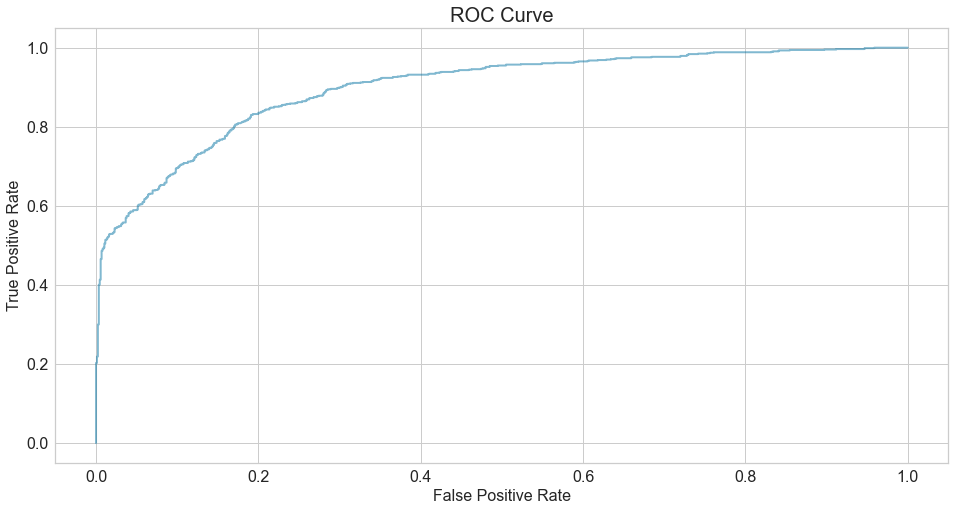

(array([0.        , 0.        , 0.        , ..., 0.99771429, 0.99885714,
        1.        ]),
 array([0.        , 0.00115741, 0.00231481, ..., 1.        , 1.        ,
        1.        ]),
 array([1.        , 0.99787584, 0.99776713, ..., 0.00954812, 0.00910588,
        0.        ]))

In [28]:
utils.get_roc_curve(model_catboost, valid_dataset_cat, plot=True)

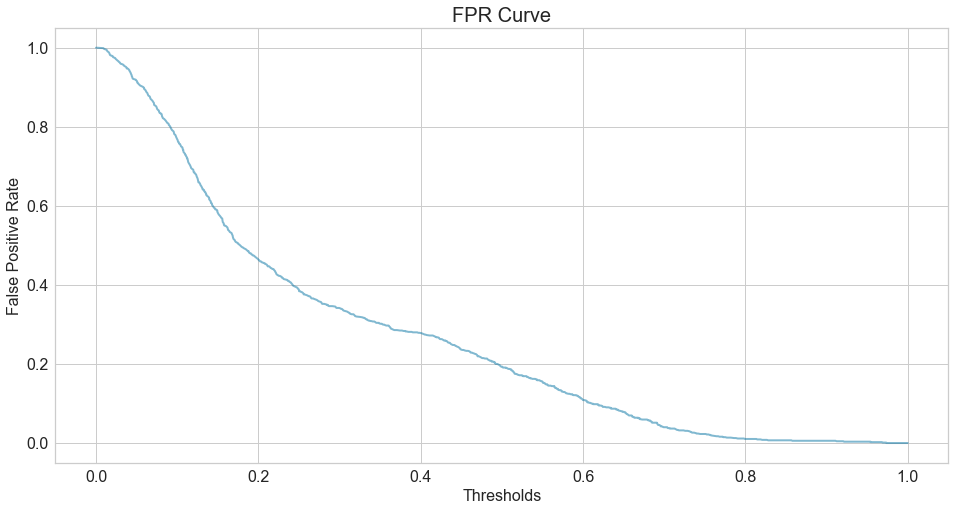

(array([1.        , 0.99787584, 0.99776713, ..., 0.00954812, 0.00910588,
        0.        ]),
 array([0.        , 0.        , 0.        , ..., 0.99771429, 0.99885714,
        1.        ]))

In [29]:
utils.get_fpr_curve(model_catboost, valid_dataset_cat, plot=True)

In [30]:
roc_auc_score(y_valid, model_catboost.predict_proba(X_valid_impute)[:, 1])

0.8979252645502646

In [31]:
accuracy_score(y_valid, model_catboost.predict(X_valid_impute) == 'True')

0.81943645773433

In [33]:
# train on full dataset
model_catboost_full = CatBoostClassifier(iterations=600, depth=10)

# Train on training dataset
model_catboost_full.fit(
    full_train_dataset_cat,
    verbose=0,
)

In [34]:
# Write predictions on the test set to a new dataframe with PassengerId and the result of the model
test_pred = pd.DataFrame(passenger_id, columns=["PassengerId"])
test_pred["Transported"] = model_catboost_full.predict(X_test_impute)
test_pred.to_csv("test_pred_catboost_bis.csv", index=False)

### Parameter Tuning

In [26]:
def objective_cat(trial):
    param = {
        "loss_function": "Logloss",
        "eval_metric": "Accuracy",
        "iterations": trial.suggest_int("iterations", 500, 2000),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-2, 10.0, log=True),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "depth": trial.suggest_int("depth", 6, 16),
        "grow_policy": trial.suggest_categorical(
            "grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]
        ),
        "one_hot_max_size": 5,
        # "rsm": trial.suggest_float("rsm", 0.2, 1),
        "leaf_estimation_method": trial.suggest_categorical(
            "leaf_estimation_method", ["Newton", "Gradient"]
        ),
        "leaf_estimation_iterations": trial.suggest_int(
            "leaf_estimation_iterations", 1, 10
        ),
        # "model_shrink_mode": trial.suggest_categorical(
        #     "model_shrink_mode", ["Constant", "Decreasing"]
        # ),
        # "model_shrink_rate": trial.suggest_float("model_shrink_rate", 0.01, 0.5),
    }

    if param["grow_policy"] == "Depthwise":
        param["score_function"] = trial.suggest_categorical(
            "score_function", ["Cosine", "L2"]
        )
        param["min_child_samples"] = trial.suggest_int("min_child_samples", 10, 100)
        param["boosting_type"] = "Plain"
    elif param["grow_policy"] == "Lossguide":
        param["max_leaves"] = trial.suggest_int("max_leaves", 16, 64)
        param["score_function"] = "L2"
        param["min_child_samples"] = trial.suggest_int("min_child_samples", 10, 100)
        param["boosting_type"] = "Plain"
    elif param["grow_policy"] == "SymmetricTree":
        param["boosting_type"] = trial.suggest_categorical(
            "boosting_type", ["Plain", "Ordered"]
        )
        if param["boosting_type"] == "Plain":
            param["score_function"] = trial.suggest_categorical(
                "score_function", ["Cosine", "L2"]
            )
        else:
            param["score_function"] = "Cosine"


    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] in ("Bernoulli", "MVS"):
        param["subsample"] = trial.suggest_float("subsample", 0.5, 1)

    print(param)

    gbm = CatBoostClassifier(**param, task_type="GPU")

    gbm.fit(
        train_dataset_cat,
        eval_set=valid_dataset_cat,
        verbose=0,
        early_stopping_rounds=100,
    )

    preds = gbm.predict(valid_dataset_cat) == "True"
    accuracy = accuracy_score(y_valid, preds)
    return accuracy


In [27]:
study_cat = optuna.create_study(direction="maximize")
study_cat.optimize(objective_cat, n_trials=8)

print("Number of finished trials: {}".format(len(study_cat.trials)))

print("Best trial:")
trial = study_cat.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2022-07-01 17:45:36,767] A new study created in memory with name: no-name-b9dc23c3-06ad-435b-bbfd-6c8ed91a22b1


{'loss_function': 'Logloss', 'eval_metric': 'Accuracy', 'iterations': 1669, 'l2_leaf_reg': 0.011013486162292294, 'bootstrap_type': 'MVS', 'depth': 9, 'grow_policy': 'Depthwise', 'one_hot_max_size': 5, 'leaf_estimation_method': 'Newton', 'leaf_estimation_iterations': 8, 'score_function': 'L2', 'min_child_samples': 12, 'boosting_type': 'Plain', 'subsample': 0.7266905868879647}


: 

: 

In [30]:
best_model_catboost = CatBoostClassifier(
    **trial.params,
)

# train on full dataset
best_model_catboost.fit(
    full_train_dataset_cat,
    verbose=False,
)

In [31]:
# Write predictions on the test set to a new dataframe with PassengerId and the result of the model
test_pred = pd.DataFrame(passenger_id, columns=["PassengerId"])
test_pred["Transported"] = best_model_catboost.predict(test_dataset_cat)
test_pred.to_csv("test_pred_catboost_optuna_8iter.csv", index=False)